ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **06Apr21**

# 06b. Poisson 2D with Dirichlet Boundary Conditions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\flux}{\boldsymbol{q}}
  \newcommand{\normal}{\boldsymbol{n}}
  \newcommand{\xpoint}{\boldsymbol{x}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \DeclareMathOperator{\div}{div}
  \DeclareMathOperator{\grad}{grad}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Plotting Functions](#plotting)
<br><br>
1. [Problem Statement](#problem)
 + [Strong Form](#dbcstrong)
 + [Variational Form](#dbcweak)
 + [Poisson-Dirichlet Energy](#energy)
<br><br>
1. [Problem Solution](#solution)
 + [MOOSE Application Development](#dbcapp)
<br><br>   
1. [Linear Lagrange FEM Results](#dbclinearfemresults)
<br><br>    
1. [Quadratic Lagrange FEM Results](#dbcquadfemresults)
<br><br>   
1. [Energy Postprocessing](#energypostpro)
<br><br>   
1. [Application Tree](#tree)
---

## [Objectives](#toc)<a id="obj"></a>

 + Extend the Poisson 1D problem covered in [Notebook 06a](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/06a-poisson-2d-dirichlet.ipynb) to a *generic* 2D case. Notes for the 1D problem must be thoroughly reviewed.
 + Introduce the Galerkin variational (weak) form of the Poisson 2D problem below ([OneNote notes here](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eib-vZHIpRlPlOMtz0Gf_asBegEFKsl9dOK4nHyDbgSeUA?e=sLu1td)).
 + <span style="color:green"> Employ a robust (but very slow) solver as an example of how to debug your code. This is particularly important as the model problem becomes more complex, in particular when it is non-linear. See the *[Preconditioning]* `MOOSE` block of the `input.hit` file below.</span>
 + <span style="color:red">Some initial code is provided in the course repository but no full source code is given out. A significant effort in programing is often necessary to learn the subject well. However the material in this course is helpful with this task. Hands-on work during lectures will try to fill in existing gap. The steps in this notebook are necessary for a basic understanding of the subject.</span>
 + You are supposed to consult the [`MOOSE source documentation`](https://mooseframework.inl.gov/source/index.html) to fill in gaps in reproducing the steps below.</span>

## [Plotting Functions](#toc)<a id="plotting"></a>

This is an auxiliary section for holding plotting functions used later.

In [1]:
'''Plot function for FEM Solution'''

def plot_solution(df, 
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(14, 5))

    ax1.plot(df['x'], df['u'],'r*-',label=basis_functions_type)

    ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
    ax1.set_ylabel(r'$u_h(x)$ [g/cc]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True)

    if 'diffFluxU_x' in df.columns:
        # create a twin x axis to be shared
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_x'],'*-', color='yellow', label='$q_{n,x}$ flux_basis_functions_type')
        ax2.set_ylabel(r"$q_h(x)$ [g/cm$^2$-s]", fontsize=16, color='yellow')
                 
        if 'diffFluxU_y' in df.columns:
            ax2.plot(df['x'], df['diffFluxU_y'],'o', color='yellow', label='$q_{n,y}$ flux_basis_functions_type')
                     
        ax2.set_ylabel(r"$q_h(x)$ [g/cm$^2$-s]", fontsize=16, color='yellow')
        ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        #ax2.set_ylim(0,2)
        #ax2.grid(True)
        


    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

## [Problem Statement](#toc)<a id="problem"></a>

The following sections describe what is referred in the literature as the two-dimensional Poisson problem with Dirichlet boundary condition.

### [Strong Form of Problem Statement](#toc)<a id="dbcstrong"></a>

Solve the Poisson model problem. Find $u:\Omega\in\Reals^2\rightarrow\Reals$ such that:

\begin{align*}
 -\div_\xpoint(-D\, \grad_\xpoint u) + S &= 0 \quad &\forall \quad \xpoint\in \Omega, \\
 u(\xpoint) &= u_\text{b}(\xpoint)            \quad &\forall \quad \xpoint\in \partial\Omega
\end{align*}
   
This problem has an analytical solution for certain domains $\Omega$ however this solution is not required here. The *flux*, $\flux:\Omega\rightarrow\Reals^2$, associated to the quantity $u$, is denoted $\flux := -D\,\grad u$, and it is often of interest as a derived quantity.

The value of the dependent variable is given on the boundary of the domain $\partial\Omega$. This is the extension of the *essential* boundary condition or  *Dirichlet boundary condition* to 2D.

### [Variational Form of Problem Statement](#toc)<a id="dbcweak"></a>

The Galerkin variational formulation is as follows. Find $u \in H^1\!\bigl(\Omega\bigr)$ so that 

\begin{align*}
 \int\limits_\Omega -D\, \grad_\xpoint u \cdot \grad_\xpoint v\,d\xpoint + \int\limits_\Omega S\,v(\xpoint)\,d\xpoint &= 0 \quad \forall \quad v \in H^1_0\!\bigl(\Omega\bigr), 
\end{align*}

where $H^1\!\bigl(\Omega\bigr) := \bigl\{ u:\Omega\subset\Reals^2\rightarrow \Reals \mid \int_\Omega \grad_\xpoint u\cdot\grad_\xpoint u\,d\xpoint < \infty \bigr\}$ and 
$H^1_0\!\bigl(\Omega\bigr) := \bigl\{ v \mid v \in H^1(\Omega), v|_{\partial\Omega} = 0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $v$ is called a test function. Because $v$ and $u$ are sought in very similar sets of functions, this variational form is called Galerkin's variational form.

The two integrals in the variational formulation are the key terms to be computed. Since the MOOSE framework performs the integration, and provides the implementation of the test function, we need to provide the integrand of the integrals, that is, the kernels. Therefore the kernels needed are:

 1. $-D\, \grad_\xpoint u \cdot \grad_\xpoint v$ ,
 1. $S\,v(\xpoint)$.
 
The kernels are to be evaluated at quadrature points provided by the MOOSE framework.

### [Poisson-Dirichlet Energy](#toc)<a id="energy"></a>

It is of theoretical and practical importance to compute the associated energy that the variational form minimizes, that is the **Poisson-Dirichlet total energy**:

\begin{align*}
 \Phi[u] := \int\limits_\Omega \,\frac{1}{2}\flux(\xpoint)\cdot\flux(\xpoint) - D\,S\,u(\xpoint) \,d\xpoint.
\end{align*}

Since this is done after the solution is computed, it is characterized as a *postprocessing* operation. In `MOOSE` this is implemented in a *Postprocessors* class. First however, any derived quantity used in the integrand needs to be passed to the preprocessor for integration. Here we need to compute the local *flux*, $q$. In `MOOSE` this is done by creating an *auxiliary* variable and a corresponding *auxiliary kernel*. Therefore there are two additional components to [setup](#energypostpro):

1. Create the auxiliary variable $\flux=-D\,\grad u$,
1. Create the posprocessor for computing $\Phi$.

## [Problem Solution](#toc)<a id="solution"></a>

There is very little to do in order to extend the work done in 1D ([Notebook 06](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/06-poisson-1d-dirichlet.ipynb)) if the programming was done with an eye towards 2D and 3D. The major work to be done is in the `MOOSE` input file.

### [MOOSE Application Development](#toc)<a id="dbcapp"></a>

We will use the same application development as in [Notebook 06](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/06-poisson-1d-dirichlet.ipynb), namely `engy5310p1`.

## [Linear Lagrange FEM](#toc)<a id="dbclinearfemresults"></a>

Solve problem with parameter values:

> + See domain below
> + u_left = 3 g/cc
> + u_right = 0 g/cc
> + u_bottom = 0 g/cc
> + u_top = 2 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: First Order Lagrange
> + num. of finite elements in the *x* direction: 20
> + num. of finite element in the *y* direction: 10

In [2]:
'''Domain'''

x_left = 0.0
x_right = 25.0
x_length = x_right - x_left

y_length = x_length/2
y_bottom = -y_length/2
y_top = -y_bottom

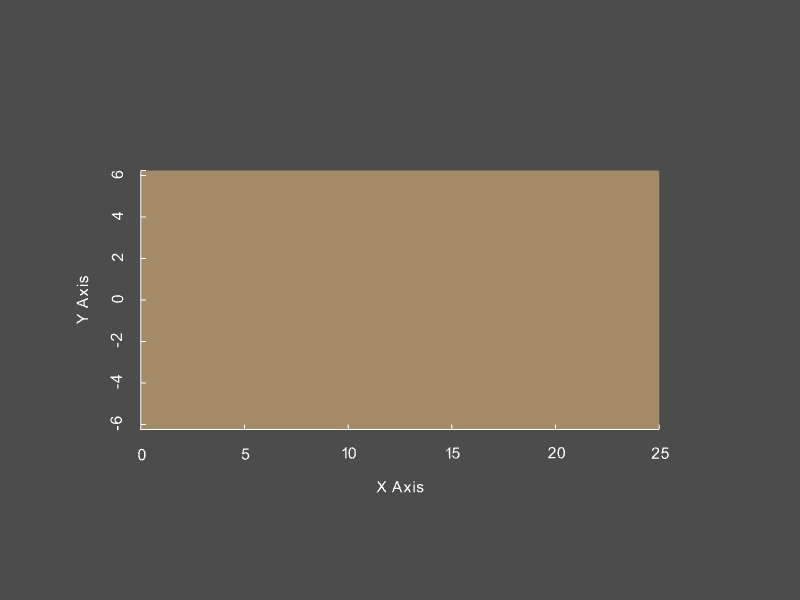

In [3]:
import pyvista as pv
import numpy as np
p1 = np.array([x_left, y_bottom, 0])
p2 = np.array([x_right, y_bottom, 0])
p3 = np.array([x_right, y_top, 0])
p4 = np.array([x_left, y_top, 0])
center = (p1+p2+p3+p4)/4
plane = pv.Plane(center=center, i_size=x_length, j_size=y_length)

plt = pv.Plotter()
plt.add_mesh(plane, color='tan')
plt.show_bounds()
plt.set_viewup([0,1,0])
cpos = plt.show(window_size=[800,600])

In [4]:
'''Parameters and data'''

diff_coeff = 0.1
source_s = 1e-3

u_left = 3.0
u_right = 0.0

u_bottom = 0
u_top = 2

In [5]:
'''FEM Solution'''

n_felem_x = 20
n_felem_y = 10

order = 'first'

n_plot_pts_x = n_felem_x + 1
n_plot_pts_y = n_felem_y + 1

from engy_5310.toolkit import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(x_left=x_left, x_right=x_right, y_bottom=y_bottom, y_top=y_top, 
                                u_left=u_left, u_right=u_right, u_bottom=u_bottom, u_top=u_top,
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, 
                                order=order, 
                                n_plot_pts_x=n_plot_pts_x, n_plot_pts_y=n_plot_pts_y, 
                                compute_diffusion_flux=True,
                                solver='fdp-newt-full')

In [6]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 19Apr21 12:58:37

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
ymin = -6.25000e+00
ymax = 6.25000e+00
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
u_left = 3.00000e+00
u_right = 0.00000e+00
u_bottom = 0.00000e+00
u_top = 2.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    nx = 20
    ny = 10
  []
[]

[Variables]
  [u]
    order = first
    family = lagrange
    initial_condition = ${fparse (u_left+u_right+u_bottom+u_top)/4}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = CONSTANT
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = CONSTANT
    family = MONOMIAL
  []
  [diffFluxU_y]
    order = CONSTANT
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = Diffu

In [7]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Mon Apr 19 12:58:37 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   
    Total:                 231
    Local:                 231
  Elems:                   
    Total:                 200
    Local:                 200
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                231
  Num Local DOFs:          231
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Auxiliary System:
  Num DOFs:                800
  Num Local DOFs:          800
 

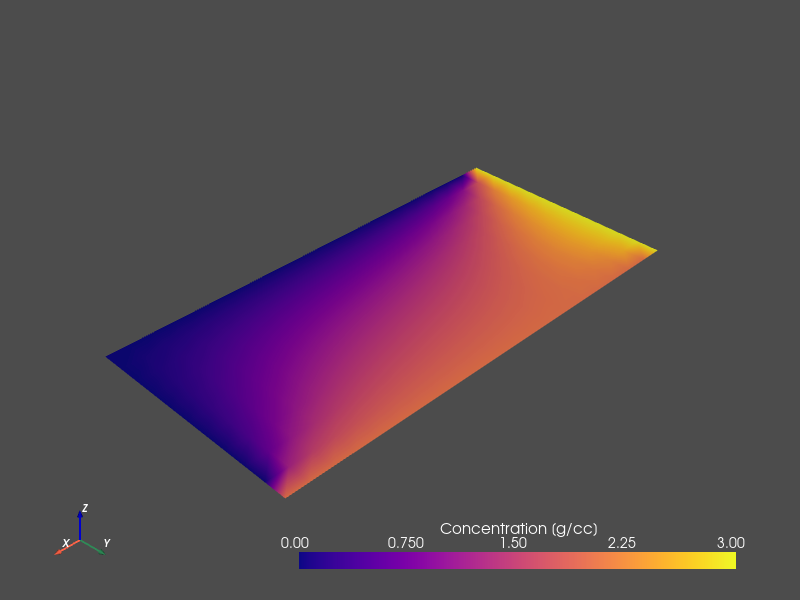

In [8]:
'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='u', stitle='Concentration [g/cc]', cmap='plasma', window_size=[800,600], notebook=True)

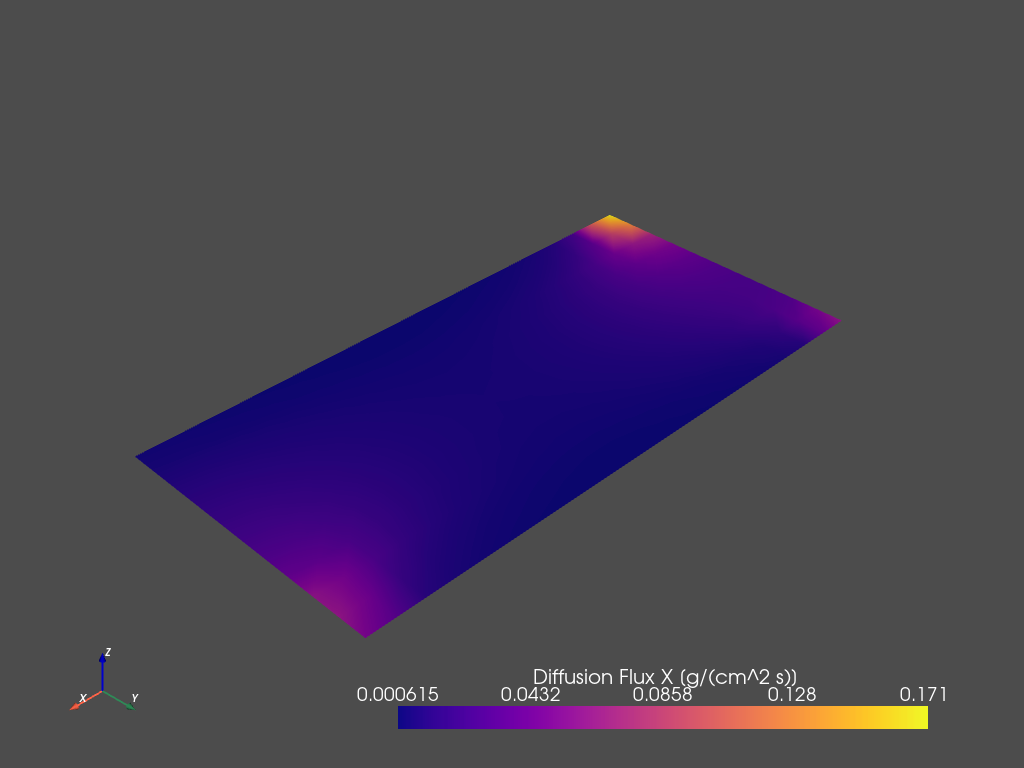

In [9]:
'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_x', stitle='Diffusion Flux X [g/(cm^2 s)]', cmap='plasma', notebook=True) 

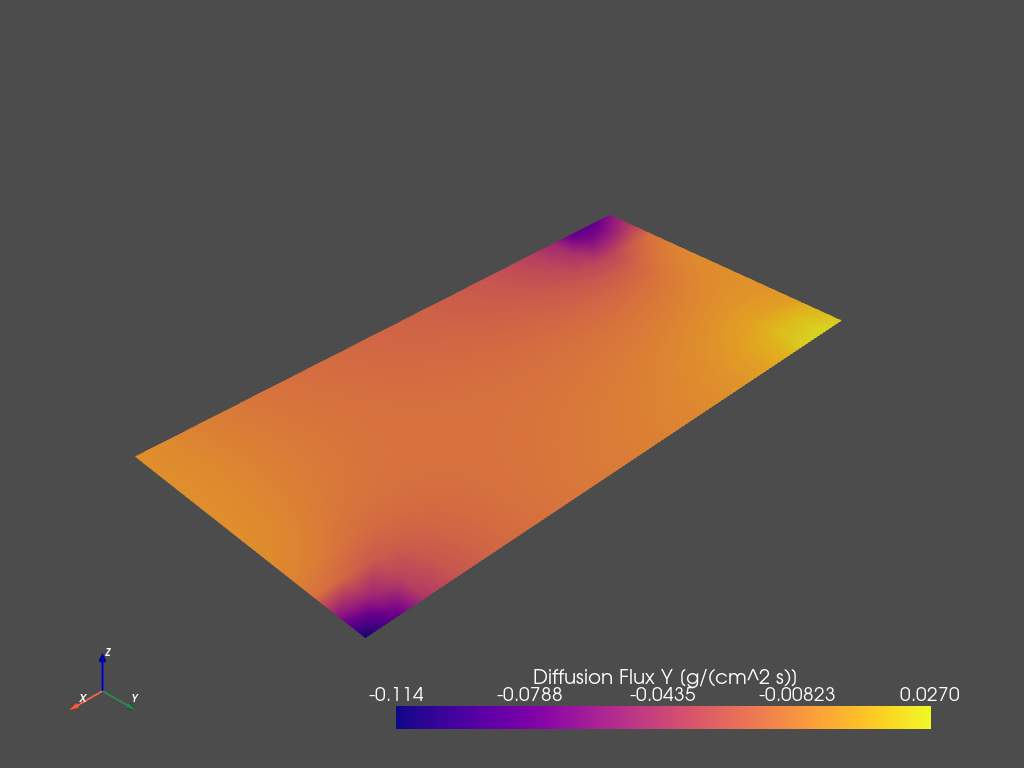

In [10]:
'''Show 2D y flux solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_y', stitle='Diffusion Flux Y [g/(cm^2 s)]', cmap='plasma', notebook=True)

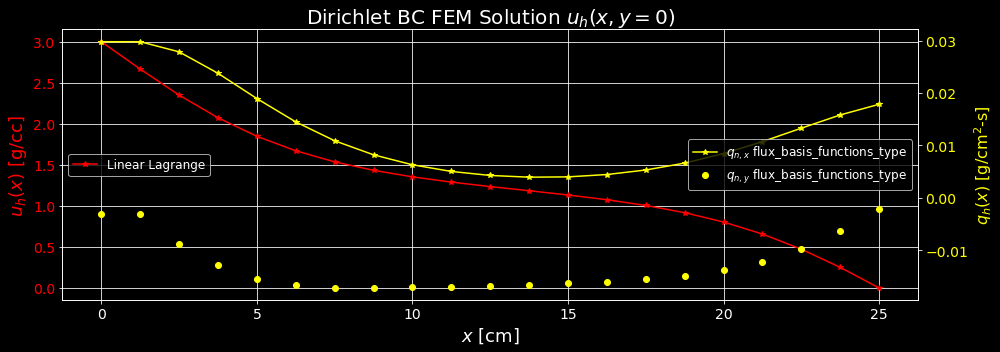

In [11]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('out-x_x-line_0002.csv')
    
plot_solution(df, title='Dirichlet BC FEM Solution $u_h(x,y=0)$', basis_functions_type='Linear Lagrange', flux_basis_functions_type='Constant Monomial')

**Comments:**

1. The *concentration* drops from the entry value to the exit as prescribed by the boundary conditions.
1. Because of the non-zero source term and BC the profile is curved.
1. The normal diffusion flux is negative on the left boundary, $(\flux\cdot\normal)|_{\xpoint = (a,y)} < 0$, 
hence there is *feeding* on the left. On the right boundary $(\flux\cdot\normal)|_{\xpoint = (a,y)} > 0$ therefore there is *draining* at the right side.

## [Quadratic Lagrange FEM](#toc)<a id="dbcquadfemresults"></a>

FEM parameters:

> + Basis Functions: Second Order Lagrange
> + num. of finite elements in the *x* direction: 20
> + num. of finite element in the *y* direction: 10

In [12]:
'''FEM Solution'''

n_felem_x = 20
n_felem_y = 10

order = 'second'

n_plot_pts_x = n_felem_x + 1
n_plot_pts_y = n_felem_y + 1

from engy_5310.toolkit import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(x_left=x_left, x_right=x_right, y_bottom=y_bottom, y_top=y_top, 
                                u_left=u_left, u_right=u_right, u_bottom=u_bottom, u_top=u_top,
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, 
                                order=order, 
                                n_plot_pts_x=n_plot_pts_x, n_plot_pts_y=n_plot_pts_y, 
                                compute_diffusion_flux=True,
                                solver='fdp-newt-full')

In [13]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 19Apr21 12:58:39

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
ymin = -6.25000e+00
ymax = 6.25000e+00
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
u_left = 3.00000e+00
u_right = 0.00000e+00
u_bottom = 0.00000e+00
u_top = 2.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    nx = 20
    ny = 10
    elem_type = QUAD9
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${fparse (u_left+u_right+u_bottom+u_top)/4}
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
  [diffFluxU_y]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
  

In [14]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Mon Apr 19 12:58:39 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   
    Total:                 861
    Local:                 861
  Elems:                   
    Total:                 200
    Local:                 200
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                861
  Num Local DOFs:          861
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                2400
  Num Local DOFs:          240

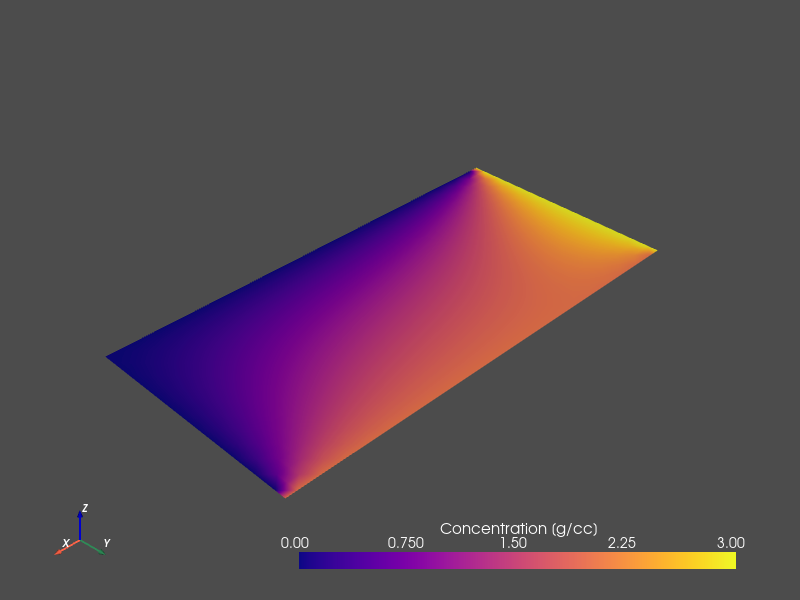

In [15]:
'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='u', stitle='Concentration [g/cc]', cmap='plasma', window_size=[800,600], notebook=True)

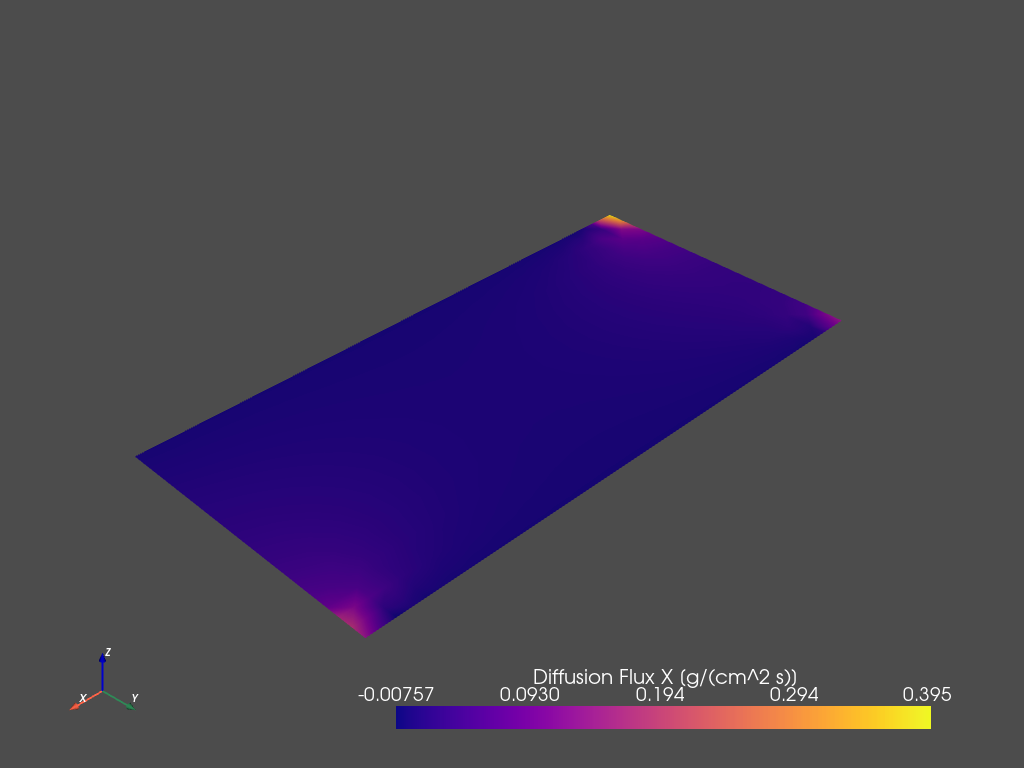

In [16]:
'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_x', stitle='Diffusion Flux X [g/(cm^2 s)]', cmap='plasma', notebook=True) 

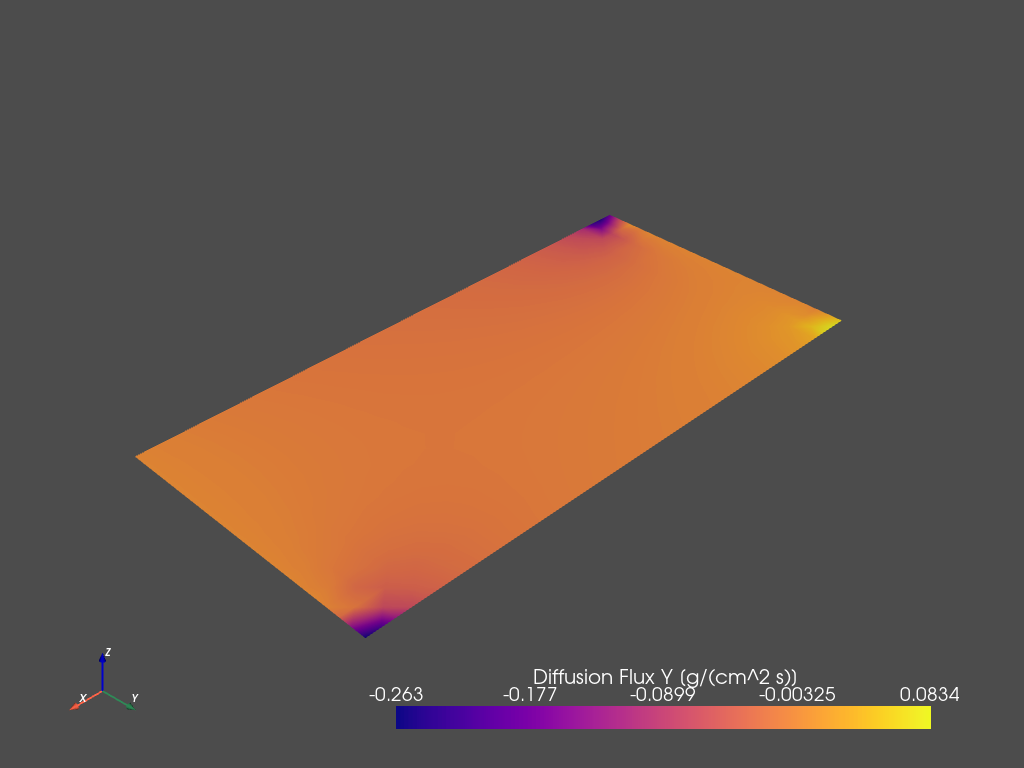

In [17]:
'''Show 2D y flux solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')
cpos = poisson.plot(scalars='diffFluxU_y', stitle='Diffusion Flux Y [g/(cm^2 s)]', cmap='plasma', notebook=True)

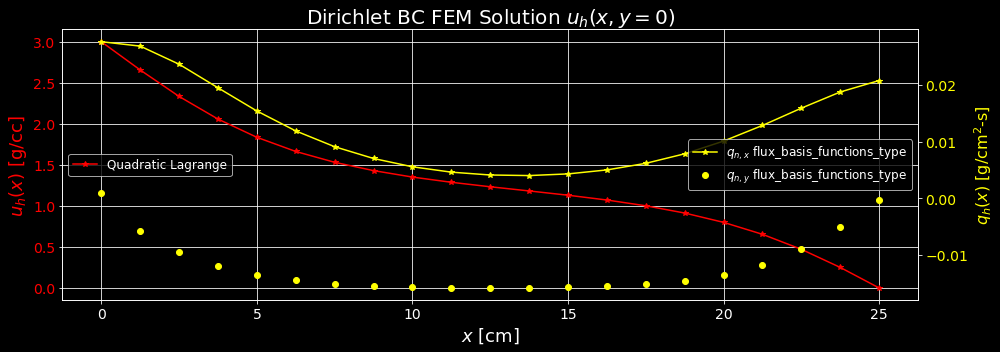

In [18]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('out-x_x-line_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution $u_h(x,y=0)$', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

## [Energy Postprocessing](#toc)<a id="energypostpro"></a>

To compute the [Poisson-Dirichlet energy](#energy) a *Postprocessor* needs to be built. The user-developed class should use the previously computed diffusion flux component. With an eye towards the future use of this application in 2D and 3D, call this new class, `BulkEnergy`.

In [19]:
'''FEM Solution'''

n_felem_x = 20
n_felem_y = 10

order = 'second'

n_plot_pts_x = n_felem_x + 1
n_plot_pts_y = n_felem_y + 1

from engy_5310.toolkit import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(x_left=x_left, x_right=x_right, y_bottom=y_bottom, y_top=y_top, 
                                u_left=u_left, u_right=u_right, u_bottom=u_bottom, u_top=u_top,
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, 
                                order=order, 
                                n_plot_pts_x=n_plot_pts_x, n_plot_pts_y=n_plot_pts_y, 
                                compute_energy=True,
                                solver='fdp-newt-full')

In [20]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 19Apr21 12:58:40

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
ymin = -6.25000e+00
ymax = 6.25000e+00
diff_coeff = 1.00000e-01
source_s = 1.00000e-03
u_left = 3.00000e+00
u_right = 0.00000e+00
u_bottom = 0.00000e+00
u_top = 2.00000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    nx = 20
    ny = 10
    elem_type = QUAD9
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
    initial_condition = ${fparse (u_left+u_right+u_bottom+u_top)/4}
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS

In [21]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit 52562be492 on 2021-04-09
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Mon Apr 19 12:58:40 2021
Executable Timestamp:    Sat Apr 17 21:27:24 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   
    Total:                 861
    Local:                 861
  Elems:                   
    Total:                 200
    Local:                 200
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                861
  Num Local DOFs:          861
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Steady
  Solver Mode:         

## [Application Tree](#toc)<a id="tree"></a>

This tree printout helps the understanding of various pieces of the `MOOSE` application repository created after all the above steps including future implementations in the notebooks following the present one that cover various boundary conditions.

In [22]:
!tree engy5310p1

engy5310p1
├── LICENSE
├── Makefile
├── README.md
├── __pycache__
│   └── chigger.cpython-38.pyc
├── build
│   ├── header_symlinks
│   │   ├── BoundaryEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BoundaryEnergy.h
│   │   ├── BulkEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BulkEnergy.h
│   │   ├── ConvectionTerm.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/kernels/ConvectionTerm.h
│   │   ├── DiffusionFlux.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFlux.h
│   │   ├── DiffusionFluxComponent.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFluxComponent.h
│   │   ├── DiffusionTerm.h 